# **Recorrido TSP**

**Librerias**

In [106]:
import networkx as nx
import dimod
from dimod import Binary
import matplotlib.pyplot as plt
from dwave.system import LeapHybridCQMSampler

**Problema**


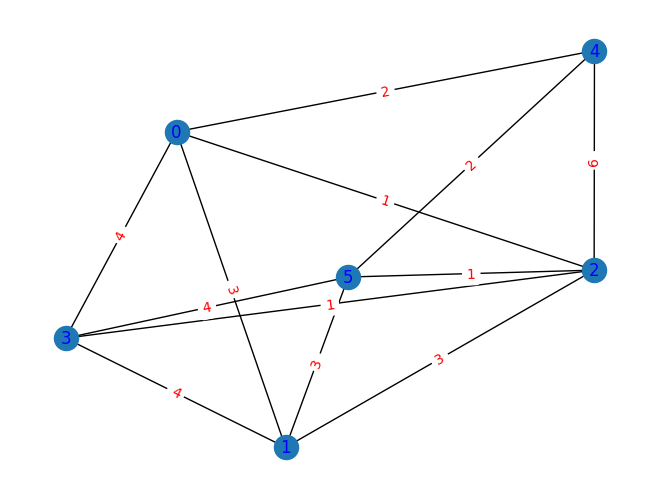

In [120]:
# Creamos el grafo

G = nx.Graph()

# Añadimos las conexiones entre nodos y sus pesos que nos indica el valor de sus aristas
# Los caminos deben ser bidireccionales

G.add_edge(0,1, weight = 3)
G.add_edge(1,0, weight = 3)
G.add_edge(0,2, weight = 1)
G.add_edge(2,0, weight = 1)
G.add_edge(0,3, weight = 4)
G.add_edge(3,0, weight = 4)
G.add_edge(0,4, weight = 2)
G.add_edge(4,0, weight = 2)
G.add_edge(1,2, weight = 3)
G.add_edge(2,1, weight = 3)
G.add_edge(1,3, weight = 4)
G.add_edge(3,1, weight = 4)
G.add_edge(2,3, weight = 1)
G.add_edge(3,2, weight = 1)
G.add_edge(2,4, weight = 6)
G.add_edge(4,2, weight = 6)

# Añadimos el nodo 5 que representa nuestro nodo 0 pero en el paso final, en este caso no es necesario crear un camino bidireccional

new_node = 5

G.add_node(new_node)

for neighbor in G.neighbors(0):
    G.add_edge(new_node, neighbor, weight=G[0][neighbor]['weight'])

# Dibujar el grafo

pos = nx.spring_layout(G)
nx.draw(G, pos)

# Obtener los pesos de las aristas y crear un diccionario

edge_labels = nx.get_edge_attributes(G, 'weight')

# Dibujar las etiquetas de las aristas

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Obtener los nombres de los nodos y crear un diccionario

node_labels = {node: str(node) for node in G.nodes()}

# Dibujar las etiquetas de los nodos

nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='blue')

# Mostrar el grafo

plt.show()

In [114]:
# Obtenemos el numero de ciudades

N = G.number_of_nodes()

# Creamos todas las variables binarias de nuestro problema TSP para un tamañano dado por N
# Necesitamos dos vairables para representar la ciudad final, el nodo 0 = 5
# Al incorporar el nodo 5 en realidad ya hemos añadido las N+1 variables de nuestro problema

x = {}
n_ciudades = N 
tiempo_max = N - 1

# Guardamos una lista de 3-tuplas en el que almacenamos solo los trios de indices (u, v, t) que permite la topologia del grafo

permitted_variables = []

for u in range(n_ciudades):
    for v in range(n_ciudades):
        for t in range(tiempo_max):
            if G.has_edge(u, v):
               permitted_variables.append((u, v, t))

# Creamos una lista de copia para poder eliminar las 3-tuplas que no aparecen debido a las C.C y las C.I de nuestro problema

permitted_variables_final = permitted_variables


# Creamos las variables binarias que estan permitidas por el grafo            

for u, v, t in permitted_variables:
    x[(u, v, t)] = Binary('x_{}_{}_{}'.format(u, v, t))


# Añadimos las C.I y C.C de nuestro problema particular

# Partimos inicialmente de la ciudad 0, esta restricción se puede implementar como la negación del complementario
# Ninguna ciudad distinta de x[(0,v,0)] puede ser visitada

for u, v, t in permitted_variables:
    if u != 0 and t==0:
       x[(u, v, t)] = 0
       permitted_variables_final.remove((u, v, t))
    
# Dado que se parte inicialmente de la ciudad 0 en t=0, podemos eliminar el resto de variabes x([0,v,t]) con t !=0

for u, v, t in permitted_variables:
    if u == 0 and t != 0:
        x[(u, v, t)] = 0
        permitted_variables_final.remove((u, v, t))

# La tercera ciudad en ser visitada es la ciudad 2, esta restricción se implementa como la negación del complementario
# Ninguna ciudad distinta de la ciudad 2 puede ser visitada en t=2. 

for u, v, t in permitted_variables:
    if v != 2 and t==2:
        x[(u, v, t)] = 0
        permitted_variables_final.remove((u, v, t))


# Dado que el camino es cerrado tenemos que imponer que la ultima ciudad visitada sea la ciudad inicial
# Por tanto tenemos que todas las variables distintas de x[(i,5,4)] son cero donde recordemos 
# Que el nodo 0 = 5 

for u, v, t in permitted_variables:
    if v != 5 and t==4:
        x[(u, v, t)] = 0
        permitted_variables_final.remove((u, v, t))
            
# Dado que el nodo 5 es el nodo 0 y dado que ademas solo puede ser visitado en ultimo lugar
# Podemos eliminar todas las variables menos la de t=4

for u, v, t in permitted_variables:
    if v==5 and t != 4: 
        x[(u, v, t)] = 0
        permitted_variables_final.remove((u, v, t))

# Dado que el nodo 5 es el nodo 0 y dado que ademas solo puede ser visitado en ultimo lugar
# Tampoco pueden salir del nodo 5

for u, v, t in permitted_variables:
    if u==5:
       x[(u, v, t)] = 0
       permitted_variables_final.remove((u, v, t))

# Creamos el modelo, es una función cuadratica binaria con restricciones asociadas

cqm = dimod.ConstrainedQuadraticModel()

# Construimos la función objetivo

cqm.set_objective(sum(x[(u, v, t)]*G[u][v]['weight'] for u, v, t in permitted_variables))

# Añadimos las restricciones asociadas al problema TSP
# 1) Solo debe salir de cada ciudad una vez:

for u, v, t in permitted_variables_final:
    if u!=5:
       cqm.add_constraint(sum(x[(u, j, k)] for i, j, k in permitted_variables_final if i==u and j>=1) == 1)
       
# 2) Hay que llegar a cada ciudad una vez:
    
for u , v, t in permitted_variables_final:
    if v != 0:
       cqm.add_constraint(sum(x[(i, v, t)] for i, j, t in permitted_variables if j==v and i!=5) == 1)

# 3) Esta restricción garantiza que no se formen se formen ciclos inconexos como solución:
 
for u, v, t in permitted_variables_final:
    if u != 0:
       cqm.add_constraint(sum(x[(u, v, t)]*x[(w, u, j)] for w, k, j in permitted_variables_final if k==u)==0)


 

print(cqm)

Constrained quadratic model: 44 variables, 115 constraints, 1193 biases

Objective
  3*Binary('x_0_1_0') + Binary('x_0_2_0') + Binary('x_0_2_2') + 4*Binary('x_0_3_0') + 2*Binary('x_0_4_0') + 3*Binary('x_1_0_1') + 3*Binary('x_1_0_3') + 3*Binary('x_1_2_1') + 3*Binary('x_1_2_2') + 3*Binary('x_1_2_3') + 4*Binary('x_1_3_1') + 4*Binary('x_1_3_3') + 3*Binary('x_1_5_3') + 3*Binary('x_1_5_4') + Binary('x_2_0_1') + Binary('x_2_0_3') + 3*Binary('x_2_1_1') + 3*Binary('x_2_1_3') + Binary('x_2_3_1') + Binary('x_2_3_3') + 6*Binary('x_2_4_1') + 6*Binary('x_2_4_3') + Binary('x_2_5_3') + Binary('x_2_5_4') + 4*Binary('x_3_0_1') + 4*Binary('x_3_0_3') + 4*Binary('x_3_1_1') + 4*Binary('x_3_1_3') + Binary('x_3_2_1') + Binary('x_3_2_2') + Binary('x_3_2_3') + 4*Binary('x_3_5_3') + 4*Binary('x_3_5_4') + 2*Binary('x_4_0_1') + 2*Binary('x_4_0_3') + 6*Binary('x_4_2_1') + 6*Binary('x_4_2_2') + 6*Binary('x_4_2_3') + 2*Binary('x_4_5_3') + 2*Binary('x_4_5_4') + 3*Binary('x_5_1_3') + Binary('x_5_2_2') + 4*Binary('x_5_3

In [122]:
# Incorporamos nuestra QPU

sampler = LeapHybridCQMSampler()

# Ejecutamos el problema en la QPU

sample_set = sampler.sample_cqm(cqm)


In [123]:
solution = sample_set.first.sample
energy = sample_set.first.energy

# Filtramos del diccionario de soluciones aquellas con valor cero, debido a que estas no pertenecen a nuestro recorrido final

for key, value in dict(solution).items():
    if value == 0:
        solution.pop(key)

print(f"La solución óptima es {solution} con energía {abs(energy)}")

print(sample_set.first)

La solución óptima es {'x_0_1_0': 1.0, 'x_2_3_3': 1.0, 'x_4_5_4': 1.0} con energía 6.0
Sample(sample={'x_0_1_0': 1.0, 'x_0_2_0': 0.0, 'x_0_2_2': 0.0, 'x_0_3_0': 0.0, 'x_0_4_0': 0.0, 'x_1_0_1': 0.0, 'x_1_0_3': 0.0, 'x_1_2_1': 0.0, 'x_1_2_2': 0.0, 'x_1_2_3': 0.0, 'x_1_3_1': 0.0, 'x_1_3_3': 0.0, 'x_1_5_3': 0.0, 'x_1_5_4': 0.0, 'x_2_0_1': 0.0, 'x_2_0_3': 0.0, 'x_2_1_1': 0.0, 'x_2_1_3': 0.0, 'x_2_3_1': 0.0, 'x_2_3_3': 1.0, 'x_2_4_1': 0.0, 'x_2_4_3': 0.0, 'x_2_5_3': 0.0, 'x_2_5_4': 0.0, 'x_3_0_1': 0.0, 'x_3_0_3': 0.0, 'x_3_1_1': 0.0, 'x_3_1_3': 0.0, 'x_3_2_1': 0.0, 'x_3_2_2': 0.0, 'x_3_2_3': 0.0, 'x_3_5_3': 0.0, 'x_3_5_4': 0.0, 'x_4_0_1': 0.0, 'x_4_0_3': 0.0, 'x_4_2_1': 0.0, 'x_4_2_2': 0.0, 'x_4_2_3': 0.0, 'x_4_5_3': 0.0, 'x_4_5_4': 1.0, 'x_5_1_3': 0.0, 'x_5_2_2': 0.0, 'x_5_3_1': 0.0, 'x_5_4_1': 0.0}, energy=6.0, num_occurrences=1, is_satisfied=array([ True,  True, False,  True,  True,  True,  True, False,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        T